Epoch:  0  Loss:  -2.9307468
Mean Squared Error:  0.41638112


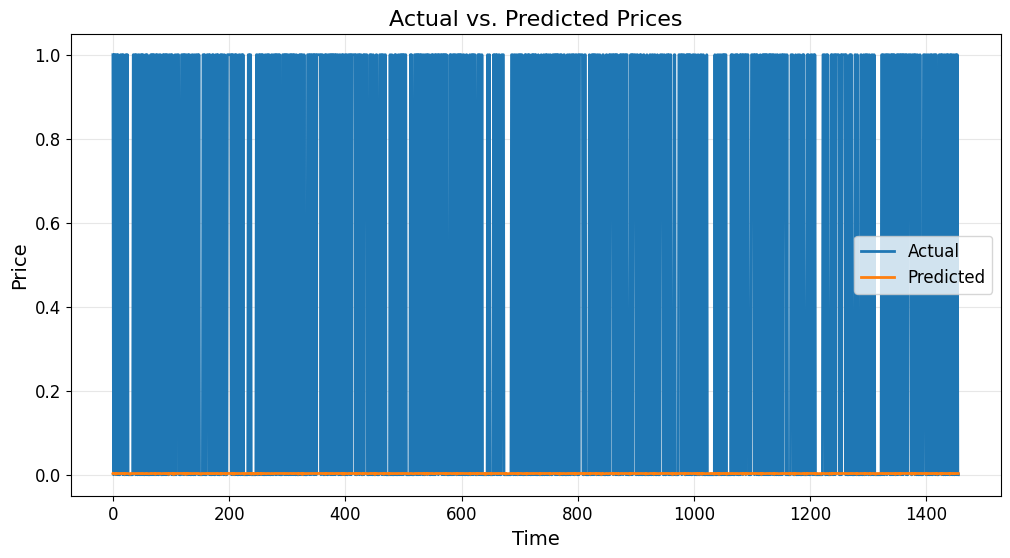

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load data
data = pd.read_csv('DATASET7k.csv')

# Preprocess data
# For example, encode the data in a binary format or scale it to be within a certain range
# Convert date strings to datetime objects
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

# Extract year, month, and day from datetime objects
data['YEAR'] = data['Date'].dt.year
data['MONTH'] = data['Date'].dt.month
data['DAY'] = data['Date'].dt.day

# Drop the original date column
data = data.drop('Date', axis=1)

# Scale data to be within range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Convert to binary format
data_binary = (data_scaled > 0.5).astype(int)

# Split data into training and test sets
train_data, test_data = train_test_split(data_binary, test_size=0.2, random_state=42)

# Convert train and test data to NumPy arrays
train_data_np = np.array(train_data)
test_data_np = np.array(test_data)

train_data_np = train_data_np.astype('float32')
test_data_np = test_data_np.astype('float32')

train_data_df = pd.DataFrame(train_data_np)

# Define the RBM model
visible_units = len(train_data_df.columns)
hidden_units = 10

weights = tf.Variable(tf1.compat.v1.truncated_normal([visible_units, hidden_units], stddev=0.1))
visible_bias = tf.Variable(tf.zeros([visible_units]))
hidden_bias = tf.Variable(tf.zeros([hidden_units]))

# Define the energy function
def energy(v, h):
    w_times_v = tf.matmul(v, weights)
    hidden_term = tf.reduce_sum(tf.math.log(1 + tf.exp(w_times_v + hidden_bias)), axis=1)
    visible_term = tf.reduce_sum(tf.multiply(v, visible_bias), axis=1)
    return tf.negative(hidden_term + visible_term)

# Define the negative log likelihood
def negative_log_likelihood(v):
    return tf.negative(tf.reduce_mean(energy(v, tf.nn.sigmoid(tf.matmul(v, weights) + hidden_bias))))

# Define the optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Train the model
batch_size = 50
epochs = 5 # min 150-300

for epoch in range(epochs):
    for i in range(0, len(train_data_np), batch_size):
        batch = train_data_np[i:i+batch_size]
        optimizer.minimize(lambda: negative_log_likelihood(batch), var_list=[weights, visible_bias, hidden_bias])
    #ekhane 150-300 epoch
    if epoch % 5 == 0:
        print("Epoch: ", epoch, " Loss: ", negative_log_likelihood(train_data_np).numpy())

# Generate predictions on the test set
test_hidden = tf.nn.sigmoid(tf.matmul(test_data_np, weights) + hidden_bias)
test_visible = tf.nn.sigmoid(tf.matmul(test_hidden, tf.transpose(weights)) + visible_bias)
test_predictions = test_visible.numpy()

# Evaluate the model
# For example, calculate the mean squared error between the predicted and actual values
mse = np.mean(np.square(test_data_np - test_predictions))
print("Mean Squared Error: ", mse)

# Generate plot of predicted vs. actual values
# Generate plot of predicted vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(test_data_np[:,0], label='Actual', linewidth=2)
plt.plot(test_predictions[:,0], label='Predicted', linewidth=2)
plt.fill_between(np.arange(len(test_data_np)), test_data_np[:,0], test_predictions[:,0], alpha=0.1, color='gray')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted Prices', fontsize=16)
plt.legend(fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.grid(alpha=0.3)
plt.show()

